Exercise 10.

Neural machine translation with attention Tutorial  
https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import os

DATASETS_DIR = os.path.join(os.pardir, 'datasets')
FRA_ENG_DIR = os.path.join(DATASETS_DIR, 'fra-eng')
FRA_DIR = os.path.join(FRA_ENG_DIR, 'fra.txt')

In [3]:
with open(FRA_DIR, encoding='utf8') as f:
    lines = f.readlines()
    pairs = [line.split('\t') for line in lines]

In [4]:
pairs[-1]

['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
 "Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.",
 'CC-BY 2.0 (France) Attribution: tatoeba.org #2024159 (CK) & #2024564 (sacredceltic)\n']

In [5]:
fra = [fra for eng, fra, _ in pairs]
eng = [eng for eng, fra, _ in pairs]

In [6]:
fra[-1]

"Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs."

In [7]:
eng[-1]

'It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.'

In [8]:
BUFFER_SIZE = len(fra)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((fra, eng)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b"C'est une question de survie."
 b'Elle ne me dit mot de toute la soir\xc3\xa9e.'
 b'Tom doit rester \xc3\xa0 Boston ce week-end.'
 b'J\xe2\x80\x99ai d\xc3\xa9j\xc3\xa0 dit \xc3\xa0 Tom que Marie n\xe2\x80\x99\xc3\xa9tait pas l\xc3\xa0.'
 b'\xc3\x8ates-vous bless\xc3\xa9s ?'], shape=(5,), dtype=string)

tf.Tensor(
[b"It's a matter of survival." b"She didn't say a word to me all night."
 b'Tom has to stay in Boston this weekend.'
 b"I've already told Tom that Mary isn't here." b'Are you injured?'], shape=(5,), dtype=string)


In [10]:
import tensorflow_text as tf_text

example_text = tf.constant('être né dans le neuvième')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc3\xaatre n\xc3\xa9 dans le neuvi\xc3\xa8me'
b'e\xcc\x82tre ne\xcc\x81 dans le neuvie\xcc\x80me'


In [11]:
def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

être né dans le neuvième
[START] etre ne dans le neuvieme [END]


In [13]:
from tensorflow.keras.layers.experimental import preprocessing

max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size)

In [14]:
input_text_processor.adapt(fra)

input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']

In [15]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size)

output_text_processor.adapt(eng)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [16]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   31,   25,  279,    6,    1,    4,    3,    0,    0],
       [   2,   33,   12,   29,   64,  456,    6,  196,   11, 1075],
       [   2,   15,  336,  241,    7,  226,   20,  779,    4,    3]],
      dtype=int64)>

In [17]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] cest une question de [UNK] . [END]             '

Text(0.5, 1.0, 'Mask')

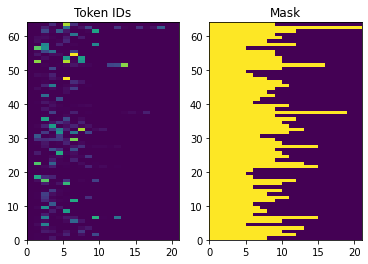

In [18]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [19]:
class ShapeChecker():
    def __init__(self):
        self.shapes = {}
        
    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        
        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        
        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]
            
            if (broadcast and new_dim == 1):
                continue
                
            if old_dim is None:
                self.shapes[name] = new_dim
                continue
                
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [20]:
embedding_dim = 256
units = 1024

In [21]:
class Encoder(keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        self.embedding = keras.layers.Embedding(self.input_vocab_size, 
                                                embedding_dim)
        self.gru = keras.layers.GRU(self.enc_units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
        
    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        return output, state

In [22]:
example_tokens = input_text_processor(example_input_batch)
encoder = Encoder(input_text_processor.vocabulary_size(), 
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 21)
Encoder output, shape (batch, s, units): (64, 21, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [23]:
class BahdanauAttention(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = keras.layers.Dense(units, use_bias=False)
        self.W2 = keras.layers.Dense(units, use_bias=False)
        self.attention = keras.layers.AdditiveAttention()
        
    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key], 
            mask=[query_mask, value_mask], 
            return_attention_scores = True)
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(units)

In [25]:
(example_tokens != 0).shape

TensorShape([64, 21])

In [26]:
example_attention_query = tf.random.normal(
    shape=[len(example_tokens), 2, 10])
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 21)


Text(0.5, 1.0, 'Mask')

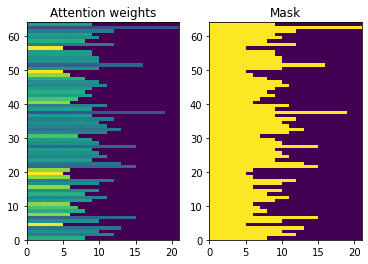

In [27]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [28]:
attention_weights.shape

TensorShape([64, 2, 21])

In [29]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

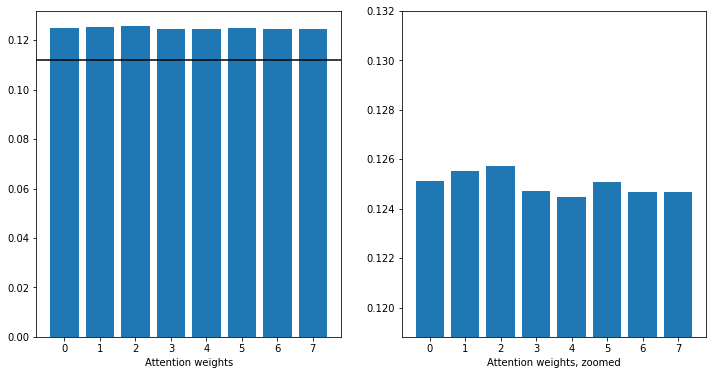

In [30]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')